In [5]:
!pip install imageio
!pip install imageio[ffmpeg]
!pip install imageio[pyav]

In [6]:
import sys 
import os
import numpy as np
sys.path.append(os.path.abspath("radars"))
from UNet import *
## in train video_make is commented
from build_model import *
from IPython.display import Video



In [7]:
import tensorflow as tf

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [9]:
radar_arr = np.load("data/radars_2020-11-01_2022-12-31.npy")
#gfs_arr = np.load("data/glorys_2020-11-01_2022-12-31.npy")
#radar_data = RadarDataset(data = radar_arr, device = device, days_out = 1, gfs_data = gfs_arr);

In [14]:
days_in=4

In [15]:
np.random.seed(57)
torch.manual_seed(57)

In [16]:
model = UNet(n_channels = days_in, days_out=1).to(device)
#print(model)

628it [00:24, 25.28it/s]


epoch 0,    train loss: 0.0318,  train loss len: 0,   val loss: 0.1604


628it [00:22, 27.71it/s]
628it [00:22, 27.82it/s]


epoch 2,    train loss: 0.1423,  train loss len: 0,   val loss: 0.1632


628it [00:22, 27.67it/s]
628it [00:22, 27.47it/s]


epoch 4,    train loss: 0.1423,  train loss len: 0,   val loss: 0.1632


628it [00:22, 27.56it/s]
628it [00:22, 27.65it/s]


epoch 6,    train loss: 0.1423,  train loss len: 0,   val loss: 0.1632


628it [00:22, 27.61it/s]
628it [00:22, 27.52it/s]


epoch 8,    train loss: 0.1423,  train loss len: 0,   val loss: 0.1632


628it [00:22, 27.54it/s]


Size of batch {'past': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

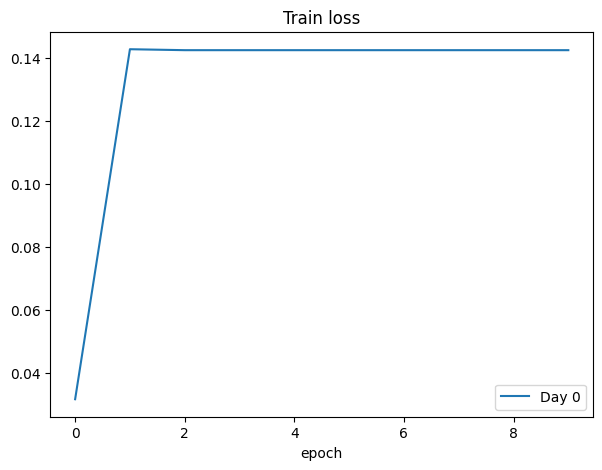

VAL PERSISTENCE: 0.1469


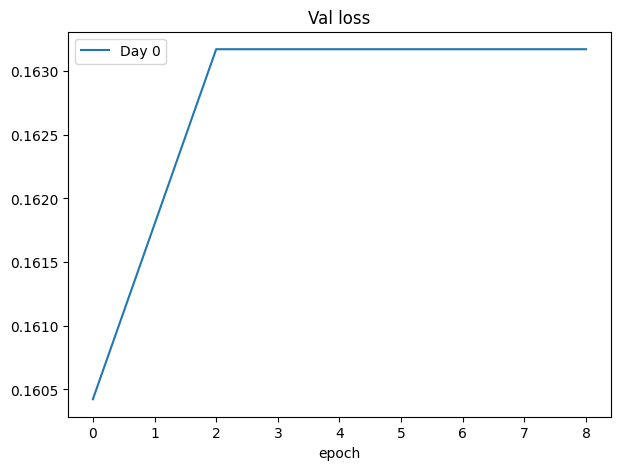

155it [00:03, 41.41it/s]


NO BLACK AREA BUGS
VAL LOSS:  0.16317198
PERS LOSS:  0.14689566


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (618, 825) to (624, 832) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to

In [18]:
[model, train_losses, val_losses, val_epochs] = train_model(model = model, dataset_arr = radar_arr, device = device, video_name = "test_unet", epochs=10, \
                                                            days_in = days_in, lr=0.001)

In [24]:
def get_pred(arr, model, device,
               train_frac=0.8, days_in=4, concat_pers=False, path_to_base_layer=None, days_out=1,
               arr_gfs=None, gfs_names=None, preds_transform=no_transform):

    val_from = int(len(arr)*train_frac)
    if arr_gfs is not None:
        arr_gfs = arr_gfs[val_from:]
    dataset_val = RadarDataset(arr[val_from:], # Как мы понимаем что в данных нет повторов?
                               days_in=days_in,
                               days_out=days_out,
                               device=device,
                               gfs_data=arr_gfs)

    dataloader_val = DataLoader(
                                dataset=dataset_val,
                                batch_size=1,
                                shuffle=False,
                                pin_memory=False,
                                )

    loss_function = MaskedLoss()
    persistence = Persistence(days_out=days_out)
    preds = None
    past = None
    pers = []
    val = []

    all_future, all_preds, all_pers, all_gfs = [], [], [], []
    history_bugs = []

    all_past = []

    for (idx, batch) in tqdm(enumerate(dataloader_val)): # two cycles: for predictions creation & for loss estimation?
                                                         # requires rewrite batch generation & eval func

        future = deepcopy(batch["future"]).float()
        future = preds_transform(future, device=device)
        past_orig = deepcopy(batch["past"].float())

        loss, _, pers_preds, loss_dict, mask = eval_model(persistence, past_orig, future, loss_function, device=device)
        pers.append(loss.cpu().detach().numpy())
        pers_preds = pers_preds.cpu().detach().numpy()[0]
        
        
#         if len(all_pers) > 0: # check that it's don't use in eval
#             pers_preds[pers_preds<=0.2] = all_pers[-1][pers_preds<=0.2]
#         #plt.imshow(pers_preds[-1])
#         #plt.show()
        all_pers.append(pers_preds)

        future = batch["future"].float()
        future = preds_transform(future, device=device)
        if past is None:
            past = batch["past"].float()

        past = past[:, :days_in, :, :] # is it ok?

        '''plt.imshow(batch["past_last_layer"][-1][-1].float())
        plt.show()'''

        '''print("PAST BEFORE CONCAT")
        plt.imshow(past[-1][-1].cpu())
        plt.show()'''

        if concat_pers:
            past[:, :-1, :, :] = past.clone()[:, 1:, :, :]
            past[:, -1:, :, :] = concat_preds_to_future(batch["past_last_layer"].float(),
                                                        past[:, -2:-1, :, :],
                                                        device=device)

        elif preds is not None:
            past[:, :-1, :, :] = past.clone()[:, 1:, :, :]
            past[:, -1:, :, :] = concat_preds_to_future(batch["past_last_layer"].float(),
                                                        preds.detach(),
                                                        device=device)

        past = torch.cat((past, batch["gfs"].float()), axis=1)


        # re-create past data right here to strictly push it into model
        loss, val_loss_len, preds, loss_dict, mask = eval_model(model, past, future, loss_function, device=device)
        # are there any ways to make black areas after this code string?

        #print("PREDS")
        # plt.imshow(preds[-1][-1].cpu().detach().numpy())
        # plt.show()
        #print('PAST SHAPE', past.shape)
        

        val.append(loss.cpu().detach().numpy())
        future = preds_transform(future, device=device)
        all_future.append(future.cpu().detach().numpy()[0])

        new_gfs = batch["gfs"].float().cpu().detach().numpy()
        for g in new_gfs:
            new_gfs[:]
        all_gfs.append(new_gfs)
        #all_preds.append(preds.cpu().detach().numpy()[0])

        preds_shape = preds.cpu().detach().numpy()[0][0].shape
        #print(preds_shape)
        if len(preds[preds<0.2]) >= 0.05 * preds_shape[0] * preds_shape[1]:
            print("PREDS WITH BLAK AREA IDX: ", idx)
            his = list(deepcopy(past.cpu().detach().numpy())[0])
            print(mask.shape)
            his.append(mask.cpu().detach().numpy())
            his.append(preds.cpu().detach().numpy()[0][0])
            his.append(future.cpu().detach().numpy()[0][0])
            history_bugs.append(np.concatenate(his, axis=1))


        all_preds.append(preds_transform(preds, device="cpu").cpu().detach().numpy()[0])
        #print('ALL PREDS SHAPE', np.array(all_preds).shape)
        all_past.append(past.cpu().detach().numpy()[0])
        #print('ALL PREDS SHAPE', np.array(all_past).shape)
    if len(history_bugs)>0:
        imageio.mimsave(f'some_files/bugs.mp4',
                        np.array(history_bugs), fps=1)
    else:
        print("NO BLACK AREA BUGS")

    all_future = np.array(all_future)
    all_preds = np.array(all_preds)
    all_pers = np.array(all_pers)
    all_gfs = np.array(all_gfs)
    all_past = np.array(all_past)

    val, pers = np.array(val), np.array(pers)
    val = val[val==val]
    pers = pers[pers==pers]
    print("VAL LOSS: ", np.mean(val))
    print("PERS LOSS: ", np.mean(pers))

    return all_future, all_preds, all_pers, all_past

(113, 825, 200)
113


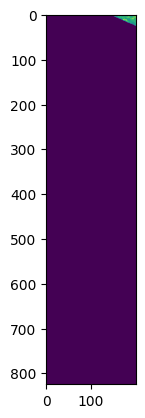

In [25]:
radar_arr = np.load("input_arr.npy")
print(radar_arr.shape)
print(radar_arr.shape[0])
plt.figure()
plt.imshow(radar_arr[10,:,:])

In [26]:
all_future, all_preds, all_pers, all_past = get_pred(train_frac=0, arr= radar_arr, model=model, device=device, days_in=days_in)

109it [00:03, 31.94it/s]


NO BLACK AREA BUGS
VAL LOSS:  0.15970097
PERS LOSS:  0.22049832


In [27]:
all_future=np.squeeze(all_future)
all_preds=np.squeeze(all_preds)
all_past=np.squeeze(all_past)
print(all_future.shape)
print(all_preds.shape)
print(all_past.shape)

(109, 825, 200)
(109, 825, 200)
(109, 4, 825, 200)


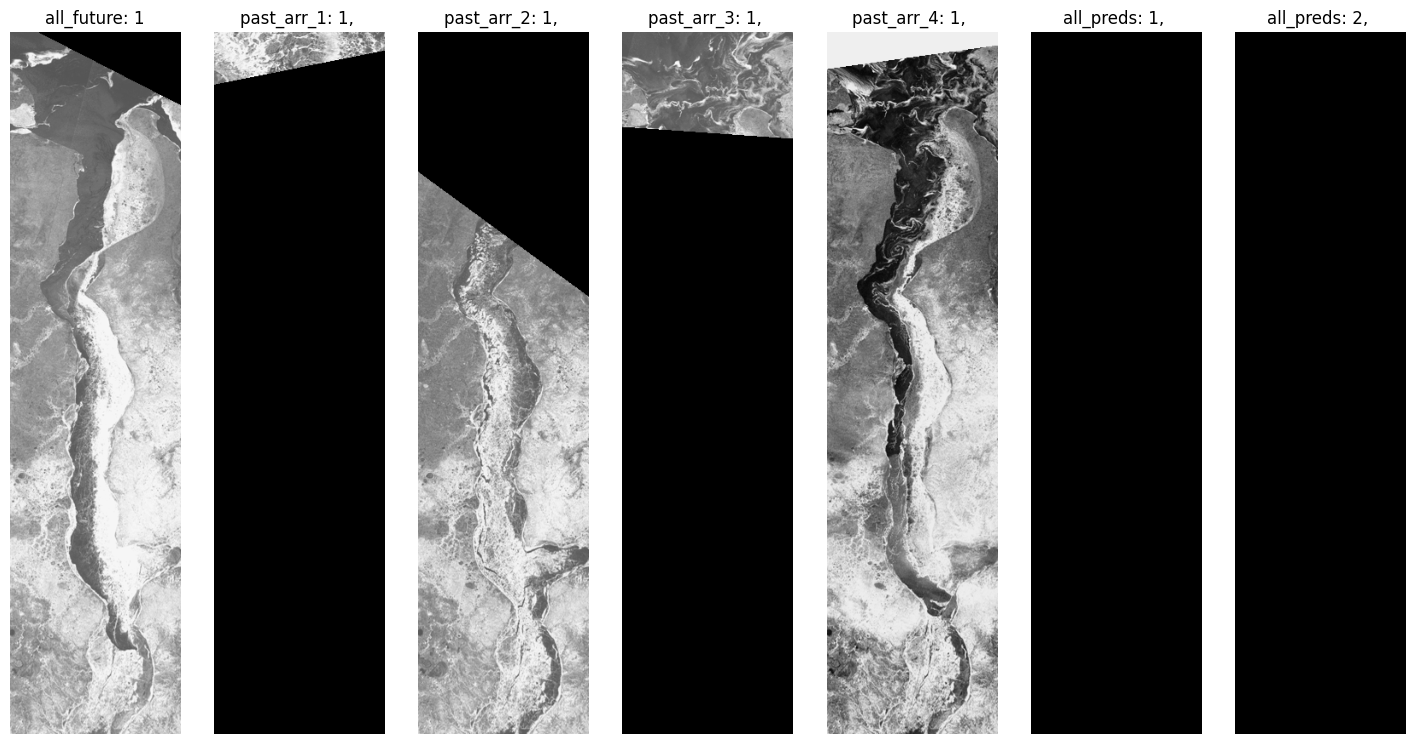

In [28]:
rows = 1
columns = 7
t = 1
# create figure
fig = plt.figure(figsize=(18, 50))
#fig = plt.figure()

for i in range(rows):
    
    fig.add_subplot(rows, columns, i*columns+1)
    plt.imshow(np.squeeze(all_future[t,:,:]), cmap='gray')
    plt.axis('off')
    plt.title("all_future: %i" %t)
    
    fig.add_subplot(rows, columns, i*columns+2)
    plt.imshow(np.squeeze(all_past[t,0,:,:]),cmap='gray')
    plt.axis('off')
    plt.title("past_arr_1: %i, " %t)
    
    fig.add_subplot(rows, columns, i*columns+3)
    plt.imshow(np.squeeze(all_past[t,1,:,:]),cmap='gray')
    plt.axis('off')
    plt.title("past_arr_2: %i, " %t)
    
    fig.add_subplot(rows, columns, i*columns+4)
    plt.imshow(np.squeeze(all_past[t,2,:,:]),cmap='gray')
    plt.axis('off')
    plt.title("past_arr_3: %i, " %t)
    
    fig.add_subplot(rows, columns, i*columns+5)
    plt.imshow(np.squeeze(all_past[t,3,:,:]),cmap='gray')
    plt.axis('off')
    plt.title("past_arr_4: %i, " %t)

    
    fig.add_subplot(rows, columns, i*columns+6)
    plt.imshow(np.squeeze(all_preds[t,:,:]),cmap='gray')
    plt.axis('off')
    plt.title("all_preds: %i, " %t)
    
    fig.add_subplot(rows, columns, i*columns+7)
    plt.imshow(np.squeeze(all_preds[t+1,:,:]),cmap='gray')
    plt.axis('off')
    plt.title("all_preds: %i, " %(t+1))

In [30]:
def prepare_output(in_image):
    image_compressed = []
    image = deepcopy(in_image)
    min_dim = min((image.shape[0], image.shape[1]))
    image = image[:min_dim, :min_dim]
    im = Image.fromarray(image)
    im.thumbnail((128, 128))
    image_compressed.append(np.array(im))
    #image_compressed = np.transpose(image_compressed, axes=[1,2,0])
    return image_compressed

In [31]:
pred_arr = [];
x_arr = [];
past_arr = []
all_preds=np.array(all_preds)
for i in range(all_preds.shape[0]):
    #print('type i:', type(i))
    #print('type radar_arr:', type(radar_arr))
    image = all_preds[i,:,:]
    pred = prepare_output(image)
    pred_arr.append(pred) 
    image = all_future[i,:,:]
    future = prepare_output(image)
    x_arr.append(future)
    past = []
    #past_arr = np.array(past_arr)
    for j in range(all_past.shape[1]):
        image = all_past[i,j,:,:]
        image = prepare_output(image)
        past.append(image)
    past_arr.append(past)

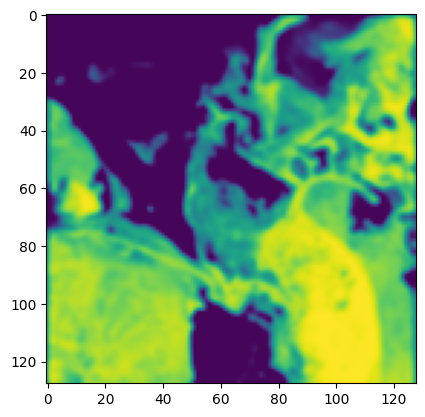

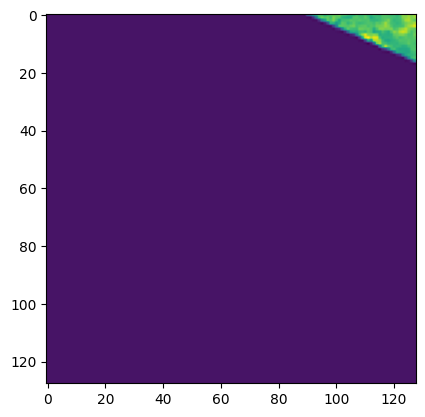

In [32]:
pred_arr = np.array(pred_arr)
pred_arr = np.squeeze(pred_arr)

x_arr = np.array(x_arr)
x_arr = np.squeeze(x_arr)

past_arr = np.array(past_arr)
past_arr = np.squeeze(past_arr)

print(pred_arr.shape)
print(x_arr.shape)
print(past_arr.shape)

In [ ]:
rows = 1
columns = 7
t = 1
# create figure
fig = plt.figure(figsize=(18, 50))
#fig = plt.figure()

for i in range(rows):
    
    fig.add_subplot(rows, columns, i*columns+1)
    plt.imshow(np.squeeze(x_arr[t,:,:]), cmap='gray')
    plt.axis('off')
    plt.title("all_future: %i" %t)
    
    fig.add_subplot(rows, columns, i*columns+2)
    plt.imshow(np.squeeze(past_arr[t,0,:,:]),cmap='gray')
    plt.axis('off')
    plt.title("past_arr_1: %i, " %t)
    
    fig.add_subplot(rows, columns, i*columns+3)
    plt.imshow(np.squeeze(past_arr[t,1,:,:]),cmap='gray')
    plt.axis('off')
    plt.title("past_arr_2: %i, " %t)
    
    fig.add_subplot(rows, columns, i*columns+4)
    plt.imshow(np.squeeze(past_arr[t,2,:,:]),cmap='gray')
    plt.axis('off')
    plt.title("past_arr_3: %i, " %t)
    
    fig.add_subplot(rows, columns, i*columns+5)
    plt.imshow(np.squeeze(past_arr[t,3,:,:]),cmap='gray')
    plt.axis('off')
    plt.title("past_arr_4: %i, " %t)

    
    fig.add_subplot(rows, columns, i*columns+6)
    plt.imshow(np.squeeze(pred_arr[t,:,:]),cmap='gray')
    plt.axis('off')
    plt.title("all_preds: %i, " %t)
    
    fig.add_subplot(rows, columns, i*columns+7)
    plt.imshow(np.squeeze(pred_arr[t+1,:,:]),cmap='gray')
    plt.axis('off')
    plt.title("all_preds: %i, " %(t+1))

In [ ]:
np.save("preds/pred_arr_unet.npy", pred_arr)
np.save("preds/x_arr_unet.npy", x_arr)